In [1]:
import ase
import ase.io
import bokeh
from bokeh.io import show
import functools
import matscipy.neighbours
import numpy as np
import pandas as pd
import pcax
import pickle
import pymatgen
from pymatgen.core import Lattice, Molecule, Structure
import matplotlib.pyplot as plt
import os
import tqdm
import sys

from analyses.nearest_neighbors import CrystalNN, VoronoiNN
import symphony.models.ptable as ptable
import pyspectra
import pyspectra.spectra
import pyspectra.utils
import pyspectra.visualize

sys.path.append('/home/songk/cmap_periodictable/')
from ptable_trends import ptable_plotter

/tmp/ipykernel_3818290/3423459191.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import jax
import jax.numpy as jnp
import jraph
from symphony import datatypes
from analyses import analysis
from symphony.data import input_pipeline_tf, input_pipeline

import e3nn_jax as e3nn
import haiku as hk
from symphony.data import fragments
from symphony.models import utils
from symphony.models.embedders import e3schnet, e3schnet_el

In [3]:
config, best_state_train, best_state_eval, metrics_for_best_state = analysis.load_from_workdir('/home/songk/workdirs/tmqm_fragments_metal_first_reduced_elementinfo/e3schnet_and_nequip/nn/max_targets_4', load_pickled_params=True)
rng = jax.random.PRNGKey(config.rng_seed)
rng, dataset_rng = jax.random.split(rng)
datasets = input_pipeline_tf.get_datasets(dataset_rng, config);

example_graph = next(datasets["test"].as_numpy_iterator());
frag = datatypes.Fragments.from_graphstuple(example_graph);
frag = jax.tree_map(jnp.asarray, frag)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13694485610254122993
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 13694485610254122993
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing 

In [ ]:
it = datasets["test"].as_numpy_iterator()

In [26]:
singletons = []
while len(singletons) < 10:
    example_graph = next(it);
    frag = datatypes.Fragments.from_graphstuple(example_graph);
    frag = jax.tree_map(jnp.asarray, frag)
    frags_unpadded = jraph.unpad_with_graphs(frag)
    mols = jraph.unbatch(frags_unpadded)
    for m in mols:
        if m.n_node == 1:
            singletons.append(m)

KeyboardInterrupt: 

In [ ]:
[s.nodes.species for s in singletons]
# hm. perhaps the starting atoms aren't currently limited to transition metals only

GraphsTuple(nodes=FragmentsNodes(positions=Array([[ 4.120222, -1.996224, -0.251871]], dtype=float32), species=Array([0], dtype=int32), focus_and_target_species_probs=Array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32)), edges=Array([], dtype=float32), receivers=Array([], dtype=int32), senders=Array([], dtype=int32), globals=FragmentsGlobals(target_positions=Array([[[-1.057314, -0.021066,  0.354471],
        [ 0.      ,  0.      ,  0.      ],
        [ 0.      ,  0.      ,  0.      ],
        [ 0.      ,  0.      ,  0.      ]]], dtype=float32), target_position_mask=Array([[1., 0., 0., 0.]], dtype=float32), target_species=Array([5], dtype=int32), stop=Array([False

In [5]:
init_embedding_dim = 64

embed_config = config.focus_and_target_species_predictor.embedder_config

def e3schnet_fn(graphs):
    model = e3schnet.E3SchNet(
    # model = e3schnet_el.E3SchNet(
        init_embedding_dim=embed_config.num_channels,
        num_interactions=embed_config.num_interactions,
        num_filters=embed_config.num_filters,
        num_radial_basis_functions=embed_config.num_radial_basis_functions,
        activation=utils.get_activation(embed_config.activation),
        cutoff=embed_config.cutoff,
        max_ell=embed_config.max_ell,
        num_species=80,
        name=f"node_embedder_focus_and_target_species_predictor_e3schnet",
        simple_embedding=embed_config.simple_embedding,
    )
    return model(graphs)

e3schnet_model = hk.transform(e3schnet_fn)

In [6]:
init_rng = jax.random.PRNGKey(0)
params = {k:v for k, v in best_state_train.params.items() if "node_embedder_focus_and_target_species_predictor_e3schnet" in k}

In [7]:
def element_to_fragment(z):
    graph = input_pipeline.ase_atoms_to_jraph_graph(ase.Atoms(numbers=[z]), range(1, 81), 5.0)
    return graph
element_fragments = [element_to_fragment(z) for z in range(1, 81)]

In [8]:
element_embeddings = jnp.array([
    e3schnet_model.apply(params, init_rng, element_fragments[i]).array[0, :64]
    for i in range(80)
])
print(element_embeddings[0].shape)

(64,)


In [9]:
embed_config.simple_embedding

False

Text(0.5, 1.0, 'PCA by row')

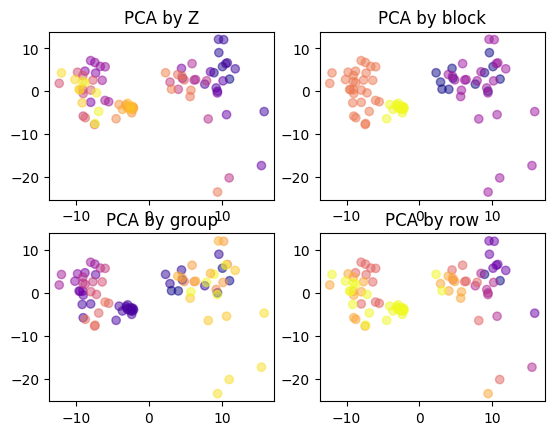

In [10]:
state = pcax.fit(element_embeddings, 2)
X = pcax.transform(state, element_embeddings)
fig, ax = plt.subplots(2, 2)
ax[0, 0].scatter(X[:, 0], X[:, 1], c=range(80), cmap='plasma', alpha=0.5)
ax[0, 0].set_title(f'PCA by Z')
ax[0, 1].scatter(X[:, 0], X[:, 1], c=ptable.blocks[:80], cmap='plasma', alpha=0.5)
ax[0, 1].set_title(f'PCA by block')
ax[1, 0].scatter(X[:, 0], X[:, 1], c=ptable.groups[:80], cmap='plasma', alpha=0.5)
ax[1, 0].set_title(f'PCA by group')
ax[1, 1].scatter(X[:, 0], X[:, 1], c=ptable.rows[:80], cmap='plasma', alpha=0.5)
ax[1, 1].set_title(f'PCA by row')

In [14]:
import plotly
from plotly import graph_objects as go
import plotly.express as px

state = pcax.fit(element_embeddings, 3)
X = pcax.transform(state, element_embeddings)
X_df = pd.DataFrame(X, columns=['x', 'y', 'z'])
X_df['species'] = np.arange(1, 81)
X_df['block'] = ptable.blocks[:80]
X_df['group'] = ptable.groups[:80]
X_df['row'] = ptable.rows[:80]

In [20]:
fig = px.scatter_3d(X_df, x='x', y='y', z='z', color='group')
fig.show()